In [1]:
from model import mosm_model
import numpy as np

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -373.479880
  Number of iterations: 50
  Number of functions evaluations: 110


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -373.479880
  Number of iterations: 50
  Number of functions evaluations: 110


                                 class prior       transform  trainable  \
GPR/kern/kernels/0/constant  Parameter  None          (none)       True   
GPR/kern/kernels/0/delay     Parameter  None  PartiallyFixed       True   
GPR/kern/kernels/0/mean      Parameter  None          (none)       True   
GPR/kern/kernels/0/noise     Parameter  None             +ve       True   
GPR/kern/kernels/0/phase     Parameter  None  PartiallyFixed       True   
GPR/kern/kernels/0/variance  Parameter  None             +ve       True   
GPR/kern/kernels/1/constant  Parameter  None          (none)       True   
GPR/kern/kernels/1/delay     Parameter  None  PartiallyFixed       True   
GPR/kern/kernels/1/mean      Parameter  None          (none)       True   
GPR/kern/kernels/1/noise     Parameter  None             +ve       True   
GPR/kern/kernels/1/phase     Parameter  None  PartiallyFixed       True   
GPR/kern/kernels/1/variance  Parameter  None             +ve       True   
GPR/kern/kernels/2/consta

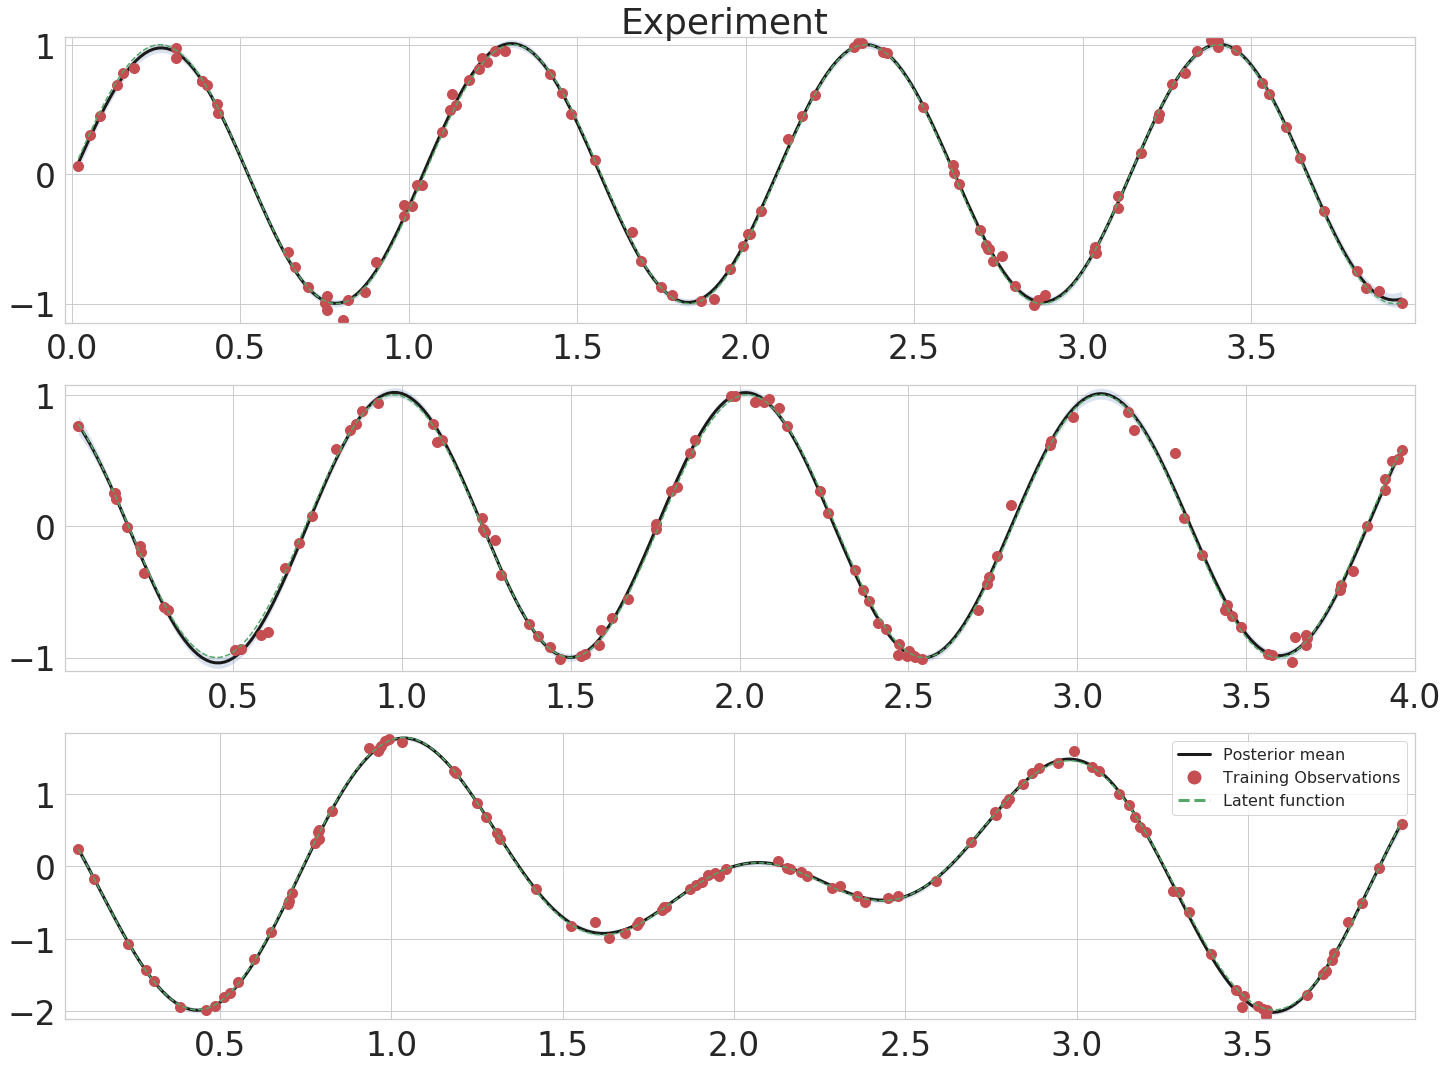

In [4]:
#First, a simple example for 3 sine curves.
def latent1(x):
    return np.sin(6*x)

def latent2(x):
    return np.sin(6*x + 2)

def latent3(x):
    return np.sin(6*x + 2) - np.sin(4*x)

X_list = []
#We construct a new set of observations, noting that observations must be sorted according to X axis.
for new_observation in range(3):
    X_list.append(np.sort(np.random.uniform(0, 4, 100)))

y_list = []
y_list.append(np.sin(6*X_list[0]) + np.random.standard_t(3, X_list[0].shape)*0.03)
y_list.append(np.sin(6*X_list[1] + 2) + np.random.standard_t(3, X_list[1].shape)*0.03)
y_list.append(np.sin(6*X_list[2] + 2) - np.sin(4*X_list[2]) + np.random.standard_t(3, X_list[2].shape)*0.03)

#We define the model, stating the number of components Q.
model = mosm_model(3)
#Since we know the functions that we're trying to approximate we can declare a 
#set of latent functions. The first argument is the set of functions, and the
#second argument contains the corresponding channels. This is entirely optional.
model.define_latent_functions([latent1, latent2, latent3], [0,1,2])

#The model needs a specific format, so we transform our observations
#to comply with it.
X, y = model.transform_lists_into_multioutput_format(X_list, y_list)
model.add_training_data(X,y)

#We fit the model, for a max of 50 iterations.
model.build_model()
model.optimize(iters = 50, display=True, anchor=True)

#We can automatically generate a prediction interval.
#First argument is the point resolution (number of points).
#The second argument contains the desired channels to predict upon.
X_pred = model.predict_interval(300, [0,1,2])

#We perform the prediction.
Y_pred, STD_pred = model.predict(X_pred)

#We can save plots for our prediction.
model.make_plots("experiment.png")
#We can inspect the trained model parameters.
print(model.as_pandas_table())

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -337.962930
  Number of iterations: 300
  Number of functions evaluations: 389


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -337.962930
  Number of iterations: 300
  Number of functions evaluations: 389


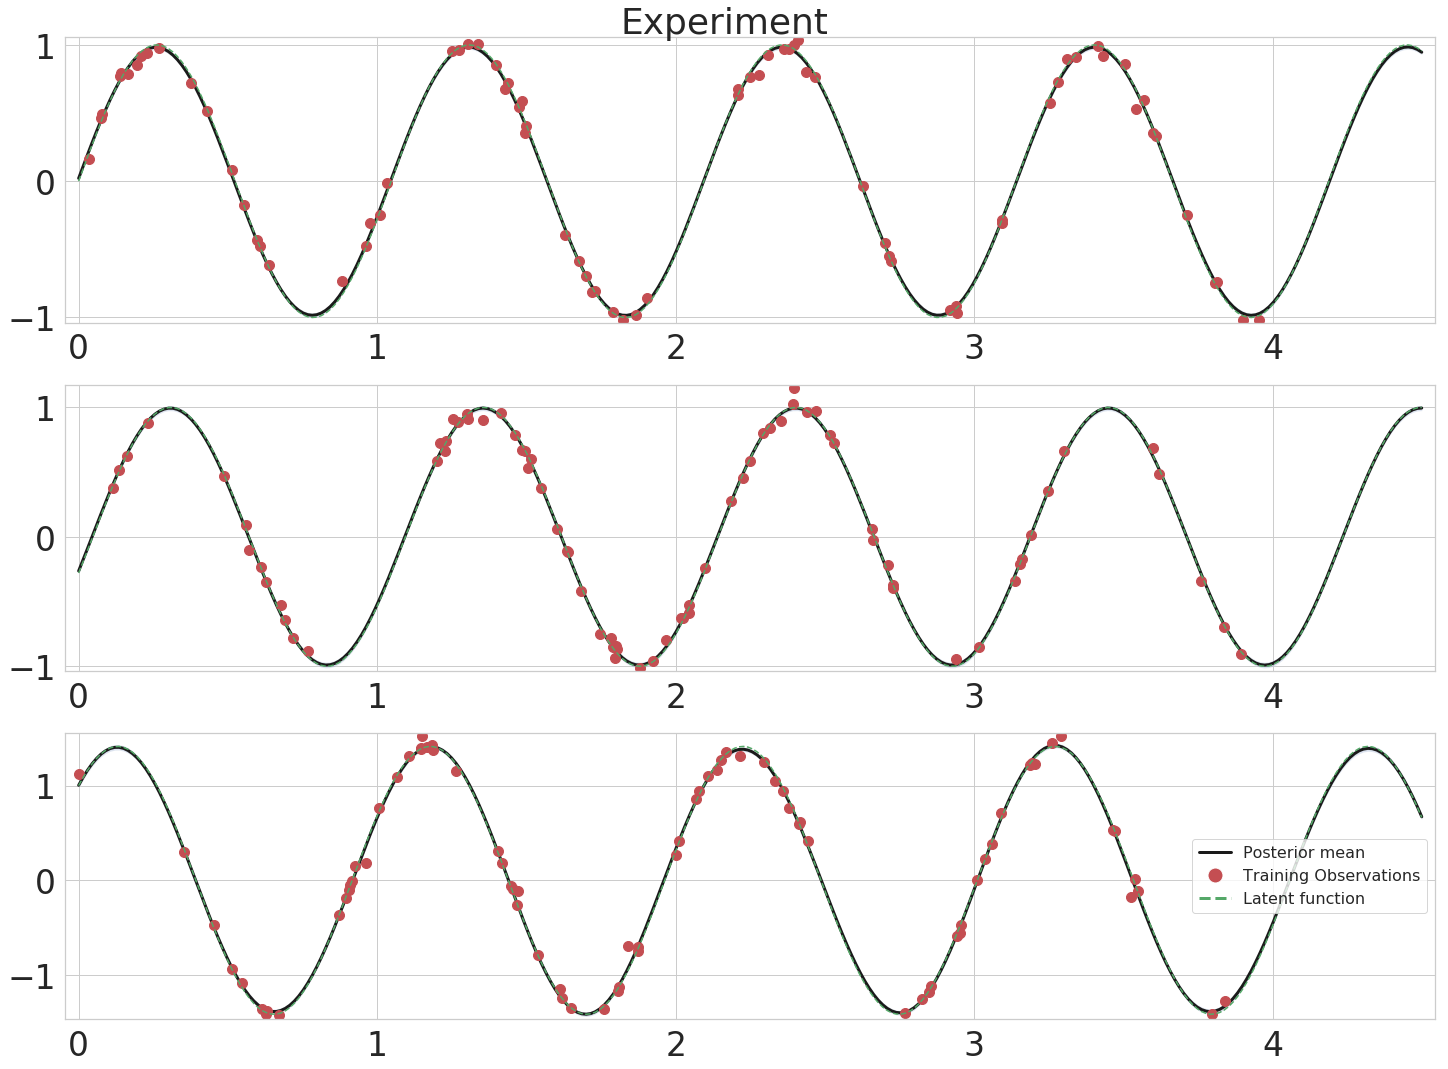

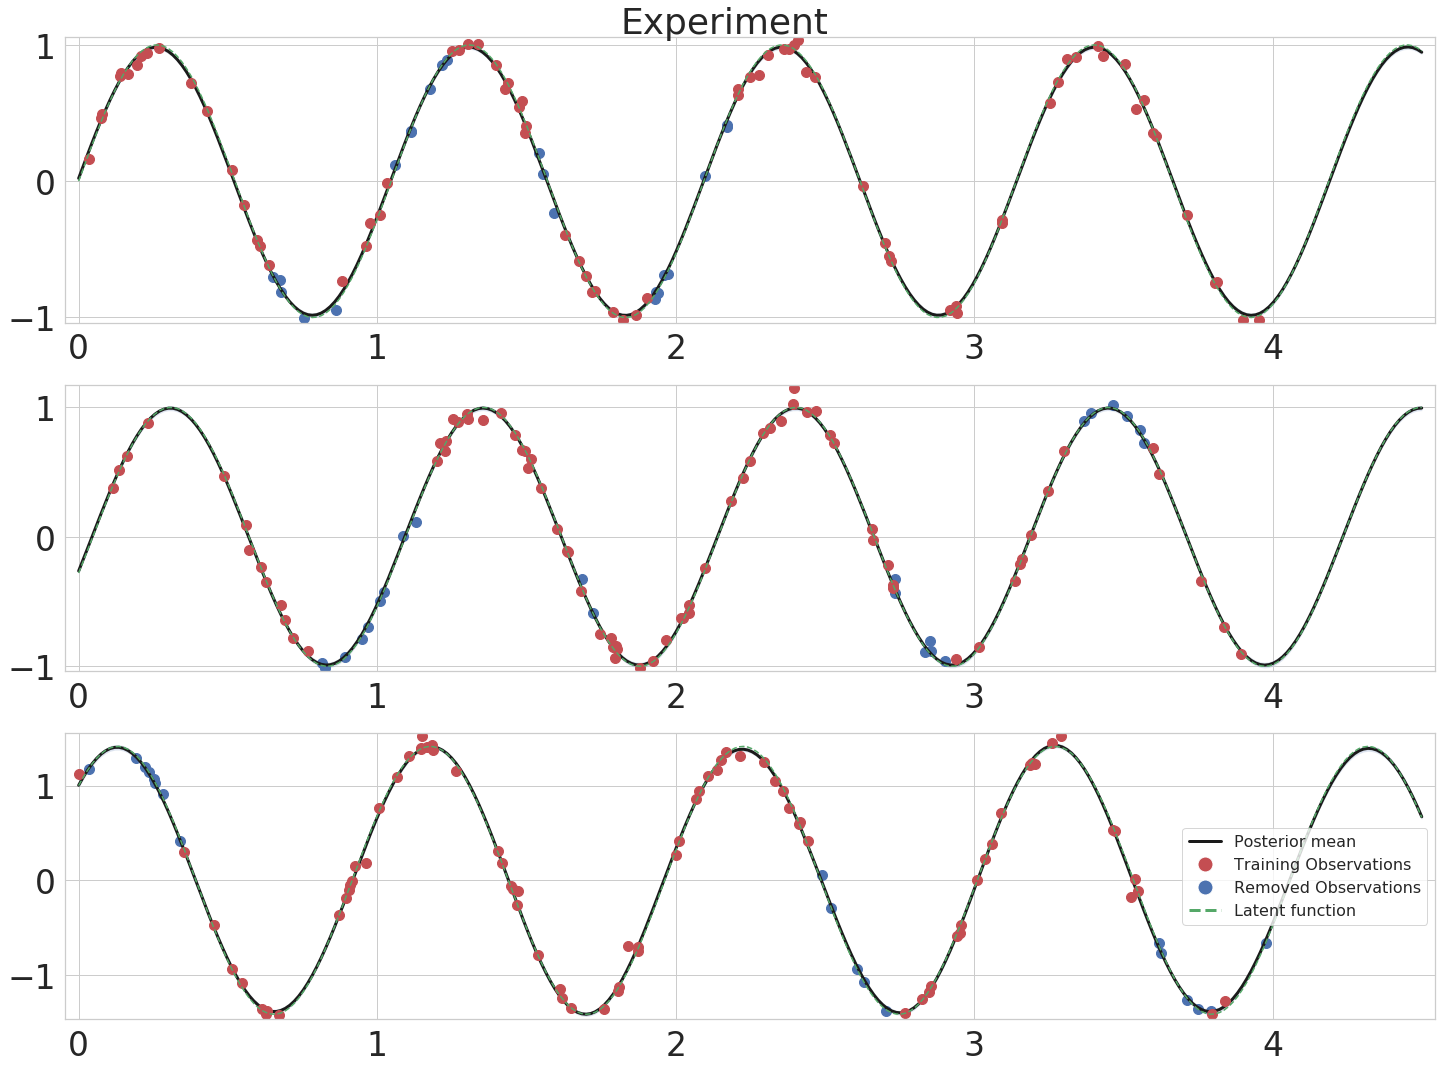

In [2]:
#In the following section we'll remove information from the channels
#to test the reconstruction capabilities offered by the model
def latent1(x):
    return np.sin(6*x)
def latent2(x):
    return np.sin(6*x + 6)
def latent3(x):
    return np.sin(6*x) + np.cos(6*x)

X_list = []
y_list = []
for new_observation in range(3):
    X_list.append(np.sort(np.random.uniform(0, 4, 100)))
    
y_list.append(np.sin(6*X_list[0]) + np.random.standard_t(3, X_list[0].shape)*0.03)
y_list.append(np.sin(6*X_list[1] + 6) + np.random.standard_t(3, X_list[1].shape)*0.03)
y_list.append(np.sin(6*X_list[2]) + np.cos(6*X_list[2]) + np.random.standard_t(3, X_list[2].shape)*0.03)

model = mosm_model(4, optimizer='L-BFGS-B')
#This method removes slabs from the time series of each channel, in order to mimic
#temporary sensor failure.
X_list_modified, y_list_modified, X_removed, y_removed = model.remove_slabs(X_list, y_list)

model.define_latent_functions([latent1, latent2, latent3], [0,1,2])

X,y = model.transform_lists_into_multioutput_format(X_list_modified, y_list_modified)
model.add_training_data(X,y)

model.build_model()
model.optimize(iters=300, display=True, anchor=True)
#This time we'll modify the prediction interval to span an extra 0.5
#First argument is point resolution
#Second argument specifies the desired channels
#Start has all the starting points, for each specified channel
#End has all the ending points, for each specified channel
X_pred = model.predict_interval(300, [0,1,2], start=[[0],[0],[0]], end=[[4.5],[4.5],[4.5]])
Y_pred, STD_pred = model.predict(X_pred)
model.make_plots("deletion_experiment.png")
#We can add all the deleted observations and make a new plot. They are marked with blue dots.
model.add_extra_observations(X_removed,y_removed,[0,1,2])
#We can specify the shape for the resulting plots, [3,1] means 3 rows 1 column.
model.make_plots("deletion_experiment_with_extra_obs.png", shape = [3,1])